In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt" , "r").read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {c : idx + 1 for idx , c in enumerate(chars)}
stoi['.'] = 0
itos = {idx : c for c , idx in stoi.items()}

In [4]:
vocab_size = len(stoi)

In [541]:
# Dataset Preperation
block_size = 8

X = []
y = []


for word in words:
    context = [0] * block_size
    word = list(word) + ['.']
    
    for ch in word:
        idx = stoi[ch]
        
        X.append(context)
        y.append(idx)
        
        context = context[1:] + [idx]
    
n1 = int(0.8 * len(X))
n2 = int(0.9 * len(X))

X_train = torch.tensor(X[:n1])
y_train = torch.tensor(y[:n1])
X_val = torch.tensor(X[n1:n2])
y_val = torch.tensor(y[n1:n2])
X_test = torch.tensor(X[n2:])
y_test = torch.tensor(y[n2:])

In [717]:
for x,y in zip(X_train[:20], y_train[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [721]:
class Linear:
    def __init__(self , fan_in , fan_out , bias=True):
        self.weight = torch.randn((fan_in , fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self , x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNormalization:
    def __init__(self , dim , eps=1e-5 , momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters training with backprops
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self , x: torch.Tensor):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim , keepdim=True)
            xvar = x.var(dim , keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self , num_of_embeddings , embedding_dim):
        self.weight = torch.randn((embedding_dim , num_of_embeddings))
    
    def __call__(self , x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x:torch.Tensor):
        X , Y , Z = x.shape
        x = x.view(X , Y // self.n , Z * self.n)
        if x.shape[1] == 1: 
            x = x.view(x.shape[0] , -1)     
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self , layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x  = layer(x)
        self.out = x
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
    
    def trainable(self, flag):
        for layer in self.layers:
            for p in self.parameters():
                p.requires_grad = flag
            if isinstance(layer, BatchNormalization):
                layer.training = flag
    
    def trainableParametersCount(self):
        return sum([p.nelement() for p in self.parameters()])
    
    def summary(self):
        for layer in self.layers:
            if isinstance(layer , Linear):
                print(layer.weight.shape)

In [722]:
torch.manual_seed(42);

In [723]:
n_embed = 10
n_hidden = 100

In [725]:
model = Sequential([
    Embedding(n_embed , vocab_size), FlattenConsecutive(2),
    Linear(2 * n_embed , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(), FlattenConsecutive(2),
    Linear(2 * n_hidden , n_hidden , bias=False) ,  BatchNormalization(n_hidden) , Tanh(), FlattenConsecutive(2),
    Linear(2 * n_hidden , vocab_size , bias=False)
])

In [726]:
with torch.no_grad():
    model.layers[-1].weight *= 0.1

In [729]:
model.trainableParametersCount()

28070

In [732]:
model.trainable(True)

# Training Data
steps = 100000
batch_size = 32
lossi = []

for step in range(steps):
    idxs = torch.randint(len(X_train) , (batch_size,))
    
    xb, yb = X_train[idxs] , y_train[idxs]
    
    # Forward Pass
    logits = model(xb)
    loss = F.cross_entropy(logits , yb)
    
    # Backpass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # Gradient Update
    lr = 0.1 if step < 150000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    # Stats
    if step % 10000 == 0:
        print(f"{step} / {steps} : {loss:.4f}")
    
    lossi.append(loss.log10().item())

0 / 100000 : 3.3004
10000 / 100000 : 2.2697
20000 / 100000 : 1.9793
30000 / 100000 : 2.4977
40000 / 100000 : 2.2790
50000 / 100000 : 1.9486
60000 / 100000 : 1.8557
70000 / 100000 : 1.4297
80000 / 100000 : 1.7938
90000 / 100000 : 2.0585


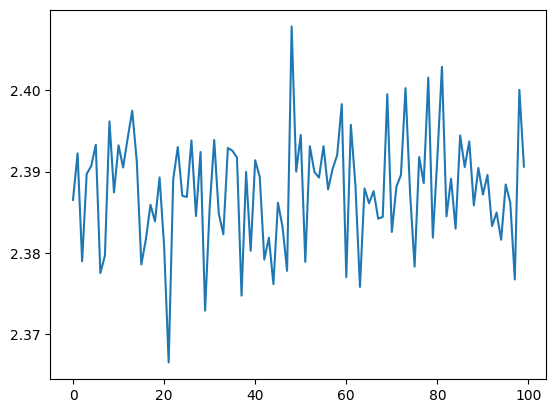

In [590]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(0))

In [740]:
model.trainable(False)

# Test Loss
logits = model(X_train)
loss = F.cross_entropy(logits , y_train)

print(f"Train {loss=}")

# Test Loss
logits = model(X_val)
loss = F.cross_entropy(logits , y_val)

print(f"Test {loss=}")

Train loss=tensor(1.9618)
Test loss=tensor(2.3053)


In [510]:
for layer in model.layers:
    if isinstance(layer , Linear):
        print("Linear")
        print(f"Weight Grad Mean : {layer.weight.grad.mean():.4f}")
        print(f"Weight Grad Std : {layer.weight.grad.std():.4f}")
        print()
    elif isinstance(layer , Embedding):
        print("Embedding")
        print(f"Weight Grad Mean : {layer.weight.grad.mean():.4f}")
        print(f"Weight Grad Std : {layer.weight.grad.std():.4f}")
        print()
    elif isinstance(layer , BatchNormalization):
        print("Batch Norm 1D")
        print(f"Gamma Grad Mean : {layer.gamma.grad.mean():.4f}")
        print(f"Gamma Grad Std : {layer.gamma.grad.std():.4f}")
        print(f"Beta Grad Mean : {layer.beta.grad.mean():.4f}")
        print(f"Beta Grad Std : {layer.beta.grad.std():.4f}")
        print()
    

Embedding
Weight Grad Mean : -0.0000
Weight Grad Std : 0.0120

Linear
Weight Grad Mean : 0.0004
Weight Grad Std : 0.0140

Batch Norm 1D
Gamma Grad Mean : -0.0007
Gamma Grad Std : 0.0060
Beta Grad Mean : 0.0013
Beta Grad Std : 0.0218

Linear
Weight Grad Mean : -0.0000
Weight Grad Std : 0.0193



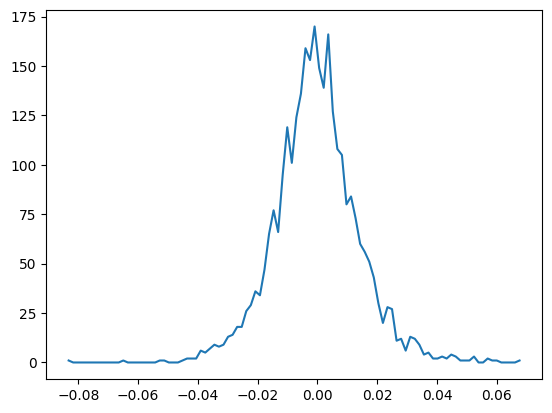

In [498]:
hy , hx = torch.histogram(model.layers[2].weight.grad)
plt.plot(hx[:-1].detach() , hy.detach())

In [764]:
model.trainable(False)

for _ in range(20):
    context = [0] * block_size
    context[5] = stoi['k']
    context[6] = stoi['h']
    context[6] = stoi['a']
    out = ['k' , 'h' , 'a']
    while True:
        logit = model(torch.tensor(context).view(1,block_size))
        probx = F.softmax(logit , dim=1)
        
        ix = torch.multinomial(probx , num_samples=1 , generator=g).item()        
        if ix == 0:
            break
        
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

khakannika
khaia
khashawna
khath
khamane
khaliya
khash
khaelyon
khastan
khashold
khason
khahansh
khashale
khadenia
khasanna
khadi
khama
khabane
khaderney
khableigh
